## Predicting Passenger Survival on the Titanic Using Decision Tree Classification

### 1. Problem
##### Goal: Predict whether a passenger survived (Survived: 0 or 1) using passenger attributes (class, age, sex, fare, family, embarkation, etc.).
##### Why Decision Tree: interpretable, handles categorical & numeric data, visualizable — great for learning and explanation.

In [7]:

import pandas as pd                                     # pandas for data manipulation
import numpy as np                                      # numpy for numerical ops
from sklearn.model_selection import train_test_split, GridSearchCV  # for splitting and hyperparameter search
from sklearn.tree import DecisionTreeClassifier, plot_tree         # Decision Tree model and plotting
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve  # evaluation metrics
import matplotlib.pyplot as plt                         # plotting
import seaborn as sns                                   # nicer plots (confusion matrix heatmap)
import warnings                                         # to manage warnings
warnings.filterwarnings("ignore")                       # ignore pandas warnings for cleaner output

### 2. Input Data (Features)
#### Download from Kaggle train.csv and rename it to Titanic.cvs. Typical columns we will use (some we will engineer):
##### - PassengerId — identifier (drop for modeling)

##### - Survived — target (0/1)

##### - Pclass — passenger class (1,2,3)

##### - Name — used to extract Title (Mr/Mrs/Miss/...)

##### - Sex — categorical

##### - Age — numeric (has missing values)

##### - SibSp — siblings / spouses aboard

##### - Parch — parents / children aboard

##### - Ticket — drop (messy)

##### - Fare — numeric

##### - Cabin — many missing (we’ll drop or optionally extract deck)

##### - Embarked — port (C/Q/S)

#### Engineered features we will create:

##### - Title (from Name) — categorical

##### - FamilySize = SibSp + Parch + 1

##### - IsAlone = FamilySize == 1

##### - AgeMissing flag (optional) — indicates Age was imputed

In [23]:
df = pd.read_csv(r".\data\Titanic.csv")                # read Kaggle Titanic Titanic.csv into a DataFrame
print(df.shape)                                        # print dataset shape (rows, cols)
#print(df.columns.tolist())                             # list column names
#print(df.head(3))                                      # show first 3 rows to understand structure
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 3. Preprocessing Steps (summary + reasoning)

##### 3.1. Inspect columns & types to confirm.

##### 3.2. Extract Title from Name to capture social status / age clues.

##### 3.3. Handle missing values:

###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Age: impute with median and add AgeMissing flag.

###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Embarked: fill with mode.

###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Fare: fill with median if missing.

###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Drop Cabin, Ticket, PassengerId, Name after extraction.

##### 3.4. Encode categorical variables:

###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Sex, Embarked, Title, IsAlone — use one-hot encoding (pd.get_dummies) because trees can also work with integers but dummy variables keep interpretation clear.

##### 3.5. Scaling: Not required for decision trees (they are scale-invariant). We'll not scale.

##### 3.6. Train/test split: 80% train, 20% test, use stratify=y to preserve survival ratio.

In [8]:
# ---------- 3. Preprocessing Steps ----------
# Extract title between comma and dot in Name, e.g. "Braund, Mr. Owen Harris" -> "Mr"
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()

# Normalize rare titles into a single group 'Rare' to reduce cardinality
rare_titles = ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
df['Title'] = df['Title'].replace(['Mlle','Ms'],'Miss')   # map Mlle and Ms to Miss
df['Title'] = df['Title'].replace(['Mme'],'Mrs')         # map Mme to Mrs
df['Title'] = df['Title'].apply(lambda x: 'Rare' if x in rare_titles else x)  # rare -> 'Rare'

# ---------- Create FamilySize and IsAlone ----------
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1         # family size includes the passenger
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)      # 1 if alone, 0 if not

# ---------- Handle missing values ----------
# Fill missing Embarked with the mode (most common port) (s)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Fill missing Fare with median (if any)
if df['Fare'].isnull().any():
    df['Fare'].fillna(df['Fare'].median(), inplace=True)

# For Age, create a missing indicator then impute median age
df['AgeMissing'] = df['Age'].isnull().astype(int)        # 1 if Age was missing, else 0
df['Age'].fillna(df['Age'].median(), inplace=True)       # impute Age with median

# ---------- Drop columns we won't use directly ----------
df_model = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])  # drop identifiers and messy columns

# ---------- Select features and target ----------
# We keep these columns as predictors
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
            'Title', 'FamilySize', 'IsAlone', 'AgeMissing']
X = df_model[features].copy()                           # copy selected features to X
y = df_model['Survived'].copy()                         # target variable (0/1)

# ---------- Encode categorical variables with one-hot encoding ----------
# pd.get_dummies will convert Sex, Embarked, Title into numeric dummy vars
X = pd.get_dummies(X, columns=['Sex', 'Embarked', 'Title'], drop_first=True)

# ---------- Sanity check numeric columns and missing values ----------
print("Features shape:", X.shape)                        # print shape after encoding
print("Any nulls in X?\n", X.isnull().sum()[X.isnull().sum() > 0])  # list any remaining nulls


Features shape: (891, 16)
Any nulls in X?
 Series([], dtype: int64)


### 4. Model & Tuning
###### - Use DecisionTreeClassifier(random_state=42).

###### - Search max_depth and min_samples_split via GridSearchCV (cv=5) using scoring='f1' or 'accuracy'. I’ll use f1 (balances precision/recall) for survival prediction.

###### - Fit best estimator on training set.

In [9]:
# ---------- Train/test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# ---------- Baseline Decision Tree training ----------
dt = DecisionTreeClassifier(random_state=42)            # initialize Decision Tree with fixed random seed
dt.fit(X_train, y_train)                                # train on training data


### 5. Evaluation

###### - Metrics: Accuracy, Precision, Recall, F1-score, Confusion Matrix, ROC AUC (since binary).

###### - Visualize learned tree with sklearn.tree.plot_tree (or export_graphviz if you want a prettier graph).

###### - Show feature importances (sorted).

In [10]:

# ---------- Evaluate baseline model ----------
y_pred = dt.predict(X_test)                             # predict labels on test set
y_proba = dt.predict_proba(X_test)[:, 1]                # predicted probabilities for positive class

print("Baseline Accuracy:", accuracy_score(y_test, y_pred))     # overall accuracy
print("Baseline F1:", f1_score(y_test, y_pred))                 # F1-score
print("\nClassification Report:\n", classification_report(y_test, y_pred))  # precision/recall/F1 per class


Baseline Accuracy: 0.8268156424581006
Baseline F1: 0.7737226277372263

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       110
           1       0.78      0.77      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



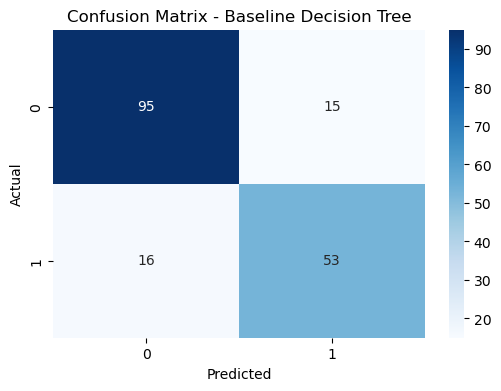

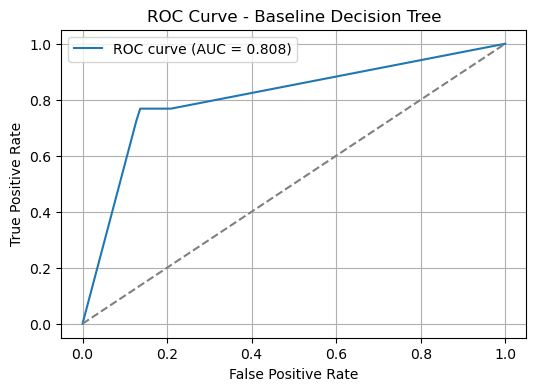

Feature importances:
 Title_Mr      0.321407
Fare          0.256957
Age           0.153559
Pclass        0.084444
FamilySize    0.053331
Title_Rare    0.031378
Embarked_Q    0.017787
Embarked_S    0.017752
AgeMissing    0.015619
Parch         0.010572
SibSp         0.009328
IsAlone       0.008178
Title_Miss    0.008112
Title_Mrs     0.006009
Sex_male      0.005567
dtype: float64
Best params: {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 20}
Best CV F1: 0.7448989960942998
Tuned Accuracy: 0.8324022346368715
Tuned F1: 0.7727272727272727

Tuned Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



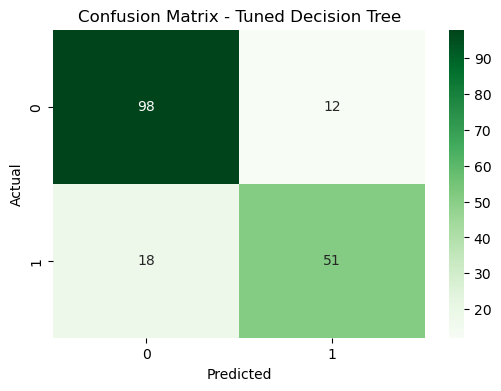

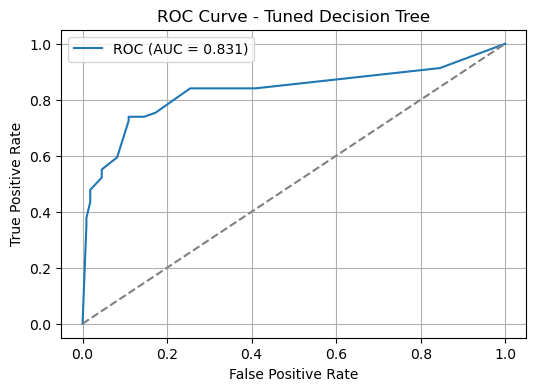

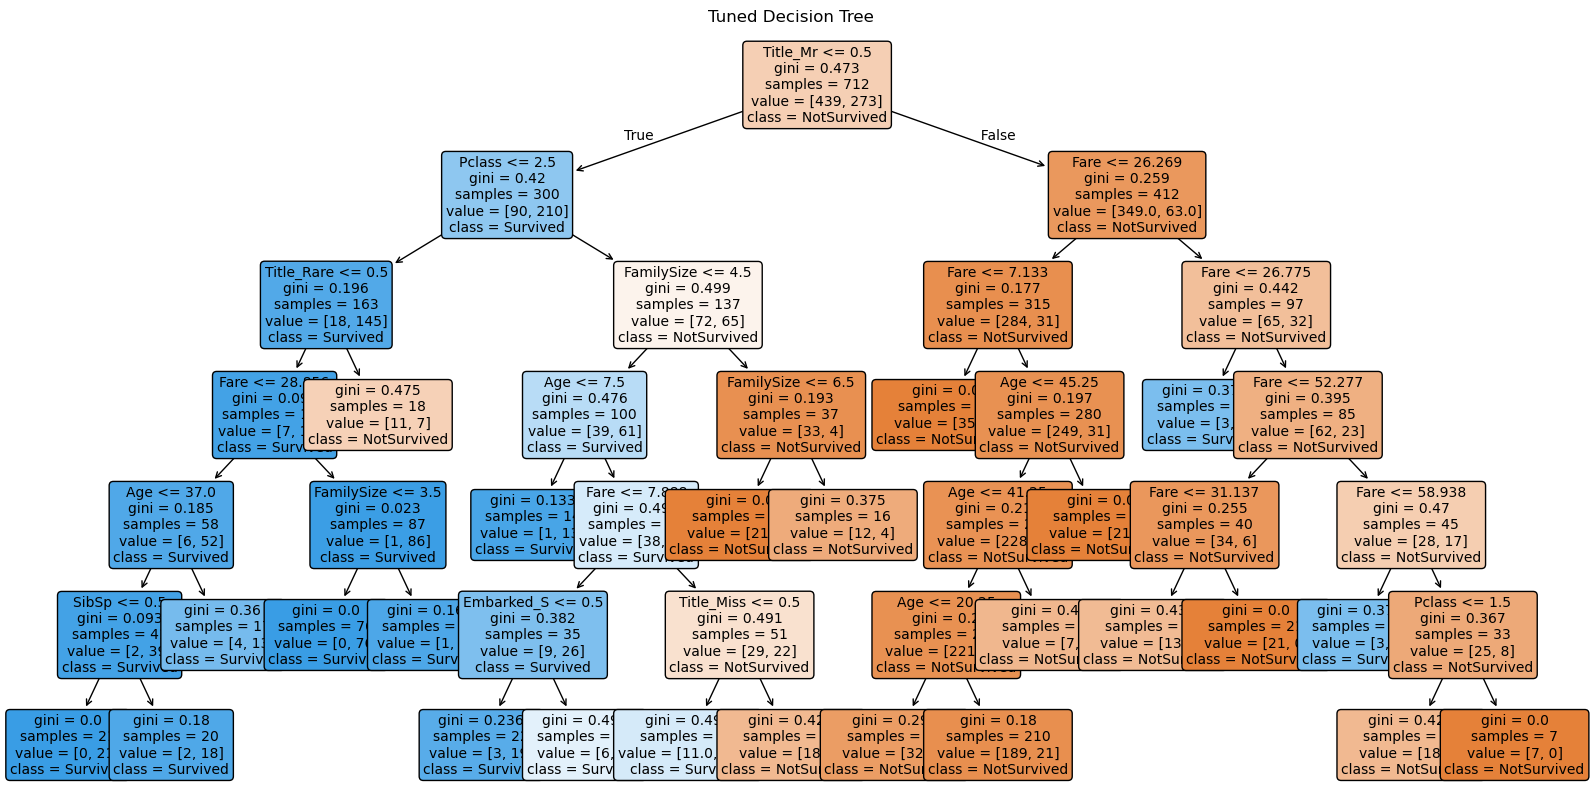

In [11]:
# ---------- Confusion matrix ----------
cm = confusion_matrix(y_test, y_pred)                   # compute confusion matrix
plt.figure(figsize=(6,4))                               # create figure
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')      # heatmap with annotations
plt.title("Confusion Matrix - Baseline Decision Tree")  # title
plt.xlabel("Predicted")                                 # x label
plt.ylabel("Actual")                                    # y label
plt.show()                                              # show plot

# ---------- ROC AUC ----------
roc_auc = roc_auc_score(y_test, y_proba)                # compute ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)       # compute ROC curve points
plt.figure(figsize=(6,4))                               # new figure
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")  # plot ROC
plt.plot([0,1],[0,1], linestyle='--', color='gray')     # diagonal guess line
plt.xlabel("False Positive Rate")                       # x label
plt.ylabel("True Positive Rate")                        # y label
plt.title("ROC Curve - Baseline Decision Tree")         # title
plt.legend()                                            # show legend
plt.grid(True)                                          # grid
plt.show()                                              # show plot

# ---------- Feature importances ----------
importances = pd.Series(dt.feature_importances_, index=X.columns)  # map importances to feature names
importances = importances.sort_values(ascending=False)   # sort descending
print("Feature importances:\n", importances.head(15))    # print top features

# ---------- Hyperparameter tuning with GridSearchCV ----------
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 8, None],              # candidate depths
    'min_samples_split': [2, 5, 10, 20],                # candidate min samples to split
    'min_samples_leaf': [1, 2, 5, 10]                   # candidate min samples per leaf
}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid,
                    scoring='f1', cv=5, n_jobs=-1)     # grid search optimizing F1 with 5-fold CV
grid.fit(X_train, y_train)                              # run grid search on training data
print("Best params:", grid.best_params_)                # print best hyperparameters
print("Best CV F1:", grid.best_score_)                  # print best CV score

# ---------- Evaluate best model on test set ----------
best_dt = grid.best_estimator_                          # retrieve best estimator from grid
y_pred_best = best_dt.predict(X_test)                   # predict with tuned model
y_proba_best = best_dt.predict_proba(X_test)[:, 1]      # predict probabilities with tuned model

print("Tuned Accuracy:", accuracy_score(y_test, y_pred_best))  # accuracy
print("Tuned F1:", f1_score(y_test, y_pred_best))              # F1
print("\nTuned Classification Report:\n", classification_report(y_test, y_pred_best))  # detailed report

# Confusion matrix for tuned model
cm2 = confusion_matrix(y_test, y_pred_best)              # confusion matrix
plt.figure(figsize=(6,4))                                # figure
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens')     # heatmap
plt.title("Confusion Matrix - Tuned Decision Tree")      # title
plt.xlabel("Predicted")                                  # x label
plt.ylabel("Actual")                                     # y label
plt.show()                                               # show plot

# ROC AUC for tuned model
roc_auc_best = roc_auc_score(y_test, y_proba_best)       # compute AUC
fpr2, tpr2, _ = roc_curve(y_test, y_proba_best)         # ROC points
plt.figure(figsize=(6,4))                               # new figure
plt.plot(fpr2, tpr2, label=f"ROC (AUC = {roc_auc_best:.3f})")  # plot ROC
plt.plot([0,1],[0,1], linestyle='--', color='gray')      # diagonal
plt.xlabel("False Positive Rate")                        # x label
plt.ylabel("True Positive Rate")                         # y label
plt.title("ROC Curve - Tuned Decision Tree")             # title
plt.legend()                                             # legend
plt.grid(True)                                           # grid
plt.show()                                               # show plot

# ---------- Plot the tuned decision tree (compact) ----------
plt.figure(figsize=(20,10))                              # big figure for readability
plot_tree(best_dt, feature_names=X.columns, class_names=['NotSurvived','Survived'], filled=True, rounded=True, fontsize=10)  # plot tree
plt.title("Tuned Decision Tree")                         # title
plt.show()                                               # show the plotted tree


### 6. Conclusion / Next steps

##### Interpret tree, check which features drive survival (Sex, Age, Pclass, Fare, FamilySize, Title often matter).

##### If performance is limited: try RandomForest, XGBoost, or do more advanced imputation (predictive), cross-validation, or feature engineering.